In [720]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2425)

## Data generation

In [721]:
# Good, but 2 CLASSES ONLY
#   alpha increases "spread"
#   beta increases "jitter"
def generate_data(n, alpha=0.1, beta=1, initial_point=[0, 0], groups=[0, 1], add_bias=True):
    data = np.empty((n, 2))
    # Define an initial point
    data[0, :] = initial_point
    
    # Randomly "scale" the upcoming reflection
    a = np.random.uniform(low=(-1-alpha), high=(-1+alpha), size=n)
    
    # "Flip" previous point and add some noise
    for k in range(1, n):
        data[k, ] = a[k]*data[k-1, :] + beta*np.random.normal(0, 1, size=2)
    
    # Add a bias variable
    if add_bias:
        data = np.hstack((np.ones((n, 1)), data))
    
    # Labels are two classes (0, 1), strictly alternating, because of "flipping" above
    labs = np.array(groups*(n//2 + 1))[:n]
    
    return data, labs

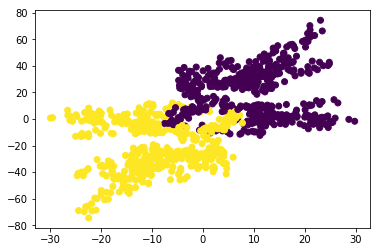

In [722]:
demo_data, demo_labs = generate_data(1000, initial_point=[10, 10])

plt.scatter(demo_data[:, 1], demo_data[:, 2], c=demo_labs)

## Auxiliary functions

In [723]:
def make_sets(data, labels, props, shuffle=True):
    
    if sum(props) != 1:
        raise ValueError("proportions must sum to 1")
    
    m = data.shape[0]
    idx = np.random.permutation(m) if shuffle else range(m)
    
    sets = []
    cursor = 0
    
    for p in props:
        dset = data[idx, :][cursor:(cursor+int(p*m)), :]
        sets.append(dset)
        lset = labels[idx][cursor:(cursor+int(p*m))]
        sets.append(lset)
        
        cursor = int(p*m)
    
    return sets

In [724]:
X_train, y_train, X_val, y_val, X_test, y_test = make_sets(demo_data, demo_labs, [0.6, 0.2, 0.2])

In [725]:
X_train.shape

(600, 3)

In [726]:
y_val.shape

(200,)

In [727]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [728]:
sigmoid(1)

0.7310585786300049

In [729]:
def predict(features, weights):
    Z = np.dot(features, weights)
    return sigmoid(Z)

In [730]:
# Must initialise weights to be different
# Otherwise complete cancellation can lead to failure
init_weights = np.random.uniform(-0.01, 0.01, 3)

In [731]:
pp = predict(X_train, init_weights)
pp.shape, pp.sum()

((600,), 300.27811125692995)

In [732]:
def classify(predictions, threshold=0.5):
    return (predictions >= threshold).astype(int)

In [733]:
classify(pp)[:10]

array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [734]:
def accuracy(predicted, actual):
    return np.mean(predicted == actual)

In [735]:
def plot_boundary(data, labels, weights, subdivs=200, alpha=0.2):
    
    fig, ax = plt.subplots()
    ax.scatter(data[:, 1], data[:, 2], c=labels)
    
    xmin, xmax = ax.get_xlim()
    xstep = (xmax-xmin)/subdivs
    ymin, ymax = ax.get_ylim()
    ystep = (ymax-ymin)/subdivs
    
    grid = np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep].reshape(2, -1).T
    n = grid.shape[0]
    grid_with_bias = np.hstack((np.ones((n, 1)), grid))
    
    ax.contourf(np.arange(xmin, xmax, xstep), np.arange(ymin, ymax, ystep),
               predict(grid_with_bias, weights).reshape(-1, subdivs).T,
               alpha = alpha)
    
    ax.scatter(data[:, 1], data[:, 2], c=labels)
    return None

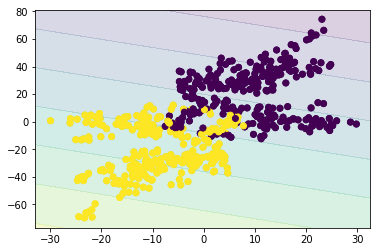

In [736]:
plot_boundary(X_train, y_train, init_weights)

## Simple logistic regression

In [737]:
def get_cost(features, labels, weights):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Log-loss cost function
    cost = -(labels*np.log(preds) + (1-labels)*np.log(1-preds)).sum()
    
    # Average cost per observation
    return cost/m
    

In [739]:
get_cost(X_train, y_train, init_weights)

0.6403235370933684

In [740]:
def get_grad(features, labels, weights):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Average gradient over all observations
    grad = np.dot(features.T, (preds - labels)) / m
    
    return grad

In [741]:
get_grad(X_train, y_train, init_weights)

array([3.79685209e-03, 4.10998863e+00, 9.33062943e+00])

In [742]:
def train(features, labels, init_weights, iters=1000, rate=0.1, tolerance=1e-6, verbose=True, report_level=100):

    cost = get_cost(features, labels, init_weights)
    
    if verbose:
        print("Training in progress...")
        print("")
        print("Iter | Cost")
        print("---- | ----")
        print("0000 |", cost)

    cost_history = np.empty(iters+1)
    cost_history[0] = cost
    weights = init_weights[:]
    
    for k in range(1, iters+1):
        
        # Update weights based on gradient of cost function
        grad = get_grad(features, labels, weights)
        weights = weights - rate*grad
        
        new_cost = get_cost(features, labels, weights)
        
        # Stopping criterion
        if abs(cost - new_cost) < tolerance:
            if verbose:
                print("Tolerance reached - terminating early!")
            
            cost_history = cost_history[:k]
            break
            
        else:        
            cost = new_cost
            cost_history[k] = cost
        
            if verbose and k % report_level == 0:
                print(str(k).zfill(4), "|", cost)
    
    if verbose:
        print("")
        print("Training complete!")
        print("Iterations completed:", k)
        print("Final cost:", cost_history[-1])
    
    return weights, cost_history

In [747]:
optw, ch = train(X_train, y_train, init_weights, rate=0.01, iters=2000, report_level=20)

Training in progress...

Iter | Cost
---- | ----
0000 | 0.6403235370933684
0020 | 0.16189756325972596
0040 | 0.15667226967764647
0060 | 0.1555360483602431
0080 | 0.1552098017654318
0100 | 0.15510442061859653
0120 | 0.15506820427978502
Tolerance reached - terminating early!

Training complete!
Iterations completed: 122
Final cost: 0.15506719915607164


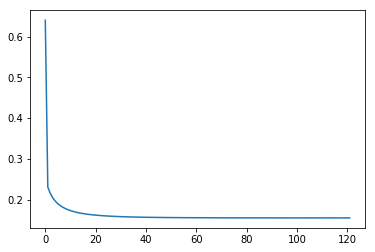

In [748]:
plt.plot(ch)

In [749]:
optw

array([ 0.00682347, -0.19780499, -0.15902459])

In [751]:
preds = predict(X_val, opt_weights)
preds_classes = classify(preds)

accuracy(preds_classes, y_val)

0.945

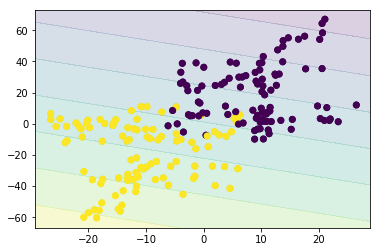

In [752]:
plot_boundary(X_val, y_val, init_weights)

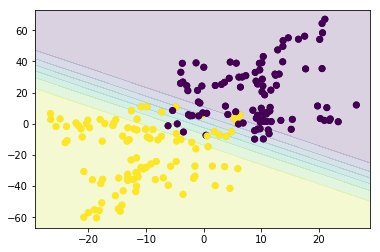

In [772]:
plot_boundary(X_val, y_val, optw)

## Variable step size

Two approaches:

* Decrease at a set rate (e.g. exponential decay)
* Adaptive decrease (e.g. backtracking)

Second approach is perhaps more expensive, but mitigated if we assume that step size **decreases** as we approach the optimum. Offers more flexibility.

In [754]:
def train(features, labels, init_weights, iters=1000, rate=0.1, tolerance=1e-6, verbose=True, report_level=100):

    cost = get_cost(features, labels, init_weights)
    
    if verbose:
        print("Training in progress...")
        print("")
        print("Iter | Cost")
        print("---- | ----")
        print("0000 |", cost)

    cost_history = np.empty(iters+1)
    cost_history[0] = cost
    weights = init_weights[:]
    
    for k in range(1, iters+1):
        
        # Update weights based on gradient of cost function
        grad = get_grad(features, labels, weights)
        
        new_weights = weights - rate*grad
        new_cost = get_cost(features, labels, new_weights)
        
        while np.isnan(new_cost) or new_cost > cost:
            if verbose:
                print("  Rate change!", rate, "->", rate/2)
            rate = rate/2
            new_weights = weights - rate*grad
            new_cost = get_cost(features, labels, new_weights)
        
        weights = new_weights
        
        # Stopping criterion
        if abs(cost - new_cost) < tolerance:
            if verbose:
                print("Tolerance reached - terminating early!")
            
            cost_history = cost_history[:k]
            break
            
        else:        
            cost = new_cost
            cost_history[k] = cost
        
            if verbose and k % report_level == 0:
                print(str(k).zfill(4), "|", cost)
    
    if verbose:
        print("")
        print("Training complete!")
        print("Iterations completed:", k)
        print("Final cost:", cost_history[-1])
    
    return weights, cost_history

In [769]:
optw, ch = train(X_train, y_train, init_weights, rate=0.1, iters=2000, report_level=5)

Training in progress...

Iter | Cost
---- | ----
0000 | 0.6403235370933684
  Rate change! 0.1 -> 0.05
  Rate change! 0.05 -> 0.025
0005 | 0.16734704500756972
0010 | 0.1594496805562646
0015 | 0.15663814761680106
0020 | 0.1556210652284501
0025 | 0.15525934599822022
0030 | 0.15513032108833433
0035 | 0.15508265354102557
0040 | 0.1550639085552731
0045 | 0.15505594070127646
Tolerance reached - terminating early!

Training complete!
Iterations completed: 46
Final cost: 0.15505594070127646


C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
C:\Users\ojones\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in multiply
  import sys


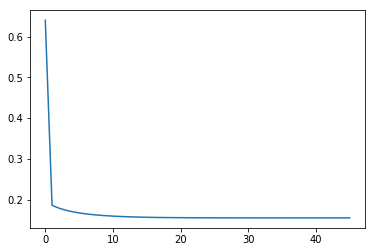

In [770]:
plt.plot(ch)

Note sharper elbow in plot.

For now, we don't see much adaptation _during_ training... though it means we don't have to be quite so careful with our initial rate (we can just set it "too high" and let the backtracking work its way back down).

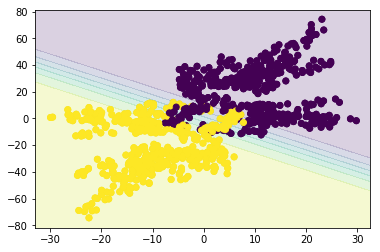

In [771]:
plot_boundary(demo_data, demo_labs, optw)